In [1]:
%load_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject


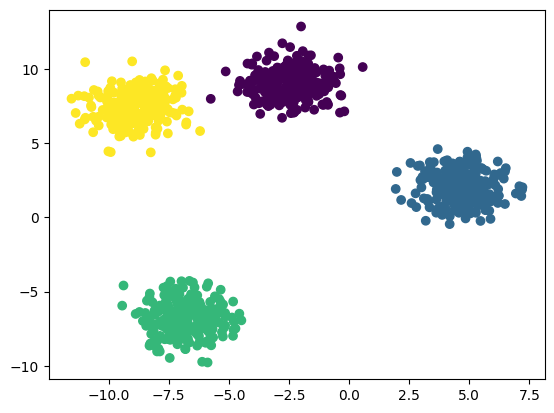

In [2]:
import manify
import torch
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

device = "cpu"

# Make data
X, y = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=42)
X = torch.tensor(X, dtype=torch.float32, device=device)
y = torch.tensor(y, dtype=torch.long, device=device)

# Plot data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from beartype.typing import Callable, Tuple, Optional
import torch
from torch import Tensor


def train_model(model, X_train, y_train, A_hat=None, num_epochs=1000, lr=0.01):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    progress_bar = tqdm(total=num_epochs)

    for i in range(num_epochs):
        # Forward pass
        if A_hat is not None:
            y_pred = model(X_train, A_hat)
        else:
            y_pred = model(X_train)

        # Compute loss
        loss = loss_fn(y_pred, y_train)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar
        progress_bar.update(1)
        progress_bar.set_postfix(loss=loss.item())

    return model


def evaluate_model(model, X_test, y_test, A_hat=None):
    with torch.no_grad():
        if A_hat is not None:
            y_pred = model(X_test, A_hat)
        else:
            y_pred = model(X_test)

        acc = (y_pred.argmax(dim=1) == y_test).float().mean()
    return acc.item()


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Basic MLP classifier
mlp = torch.nn.Sequential(torch.nn.Linear(2, 2, bias=False), torch.nn.ReLU(), torch.nn.Linear(2, 4))
mlp = train_model(mlp, X_train, y_train)
mlp_accuracy = evaluate_model(mlp, X_test, y_test)
print(f"MLP accuracy: {mlp_accuracy}")

# KappaGCN (setting kappa to 2e-4 ensures we hit the non-Euclidean case in get_logits)
pm = manify.manifolds.ProductManifold([(2e-4, 2)], stereographic=True)
kgcn = manify.predictors.kappa_gcn.KappaGCN(
    pm=pm, output_dim=4, hidden_dims=[2], nonlinearity=torch.relu, task="classification"
)
kgcn = train_model(kgcn, X_train, y_train, A_hat=torch.eye(X_train.shape[0]))
kgcn_accuracy = evaluate_model(kgcn, X_test, y_test, A_hat=torch.eye(X_test.shape[0]))
print(f"KappaGCN accuracy: {kgcn_accuracy}")

  0%|          | 0/1000 [00:00<?, ?it/s]

MLP accuracy: 1.0


  0%|          | 0/1000 [00:00<?, ?it/s]

KappaGCN accuracy: 1.0


In [42]:
class VanillaGCNLayer(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.W = torch.nn.Parameter(torch.randn(in_features, out_features))

    def forward(self, X, A_hat=None):
        return A_hat @ X @ self.W


class VanillaGCN(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.layer1 = VanillaGCNLayer(in_features, out_features)
        self.layer2 = torch.nn.ReLU()
        self.layer3 = torch.nn.Linear(out_features, out_features)

    def forward(self, X, A_hat=None):
        return self.layer3(self.layer2(self.layer1(X, A_hat)))


vgcn = VanillaGCN(2, 4)
train_model(vgcn, X_train, y_train, A_hat=torch.eye(X_train.shape[0]))
vgcn_accuracy = evaluate_model(vgcn, X_test, y_test, A_hat=torch.eye(X_test.shape[0]))
print(f"VanillaGCN accuracy: {vgcn_accuracy}")

  0%|          | 0/1000 [00:00<?, ?it/s]

VanillaGCN accuracy: 1.0
